# (28) Fit — Pois + Lin — 0

**Motivation**: First fit after code cleanup. Reproduces? Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from torch.nn import functional as F
from vae.vae import PoissonVAE, ConfigPoisVAE
from vae.train_vae import TrainerVAE, ConfigTrainVAE

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Build model + trainer

In [2]:
vae = PoissonVAE(ConfigPoisVAE())
tr = TrainerVAE(model=vae, cfg=ConfigTrainVAE(lr=0.005), device='cuda:0')

In [3]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  262.7 K   |
|     ---     |    ---     |
|    fc_enc   |  131.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

poisson_uniform_c(-3.00)_DOVES_z-512_k-32_lin+lin
ep3600-b1000-lr(0.005)_beta(1:0x0.3)_temp(1.0-0.1:0.8)_gr(500)

In [4]:
vae.log_rates.detach().exp().min(), vae.log_rates.detach().exp().max()

(tensor(0.0025, device='cuda:0'), tensor(0.0494, device='cuda:0'))

## Train

In [5]:
# comment = f"..._{tr.cfg.name()}"
tr.train(comment=tr.cfg.name())

epoch # 3600, avg loss: 165.509749: 100%|█████████████████████████████████████████████████████| 3600/3600 [28:34<00:00,  2.10it/s]


## Eval

In [6]:
data, loss, rates = tr.validate(freeze=False, use_ema=False)
loss = {k: v.mean() for k, v in loss.items()}
loss['tot'] = loss['mse'] + loss['kl']
print(loss)

{'mse': 131.81052, 'kl': 31.220701, 'kl_diag': 0.060364418, 'tot': 163.03122}

In [7]:
data, loss, rates = tr.validate(freeze=True, use_ema=False)
data_ema, loss_ema, rates_ema = tr.validate(freeze=True, use_ema=True)

In [8]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(f"{vae.cfg.name()}\n{tr.cfg.name()}\n\n{loss_summary}\n")

poisson_uniform_c(-3.00)_DOVES_z-512_k-32_lin+lin
ep3600-b1000-lr(0.005)_beta(1:0x0.3)_temp(1.0-0.1:0.8)_gr(500)

{'mse': {'vae': 135.88, 'ema': 903.48}, 'kl': {'vae': 31.22, 'ema': 31.22}, 'kl_diag': {'vae': 0.06, 'ema': 0.06}}

In [9]:
tr.model.temp, tr.cfg.kl_beta

(0.1, 1.0)

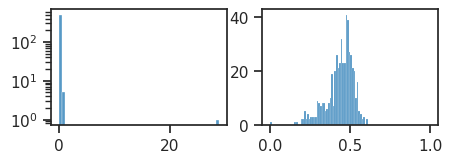

In [14]:
r8s = rates['r*dr'].mean(0)

fig, axes = create_figure(1, 2, (5, 1.5))
sns.histplot(r8s, bins=50, ax=axes[0])
sns.histplot(r8s, bins=np.linspace(0, 1, 101), ax=axes[1])
for ax in axes.flat:
    ax.set_ylabel('')
axes[0].set_yscale('log')
plt.show()

In [15]:
w_dec = tr.model.fc_dec.weight.T.reshape(tr.model.shape)
w_dec = to_np(w_dec[np.argsort(r8s)])
grid_dec = make_grid(w_dec, (16, 32))

w_dec.shape, grid_dec.shape

((512, 1, 16, 16), (271, 543))

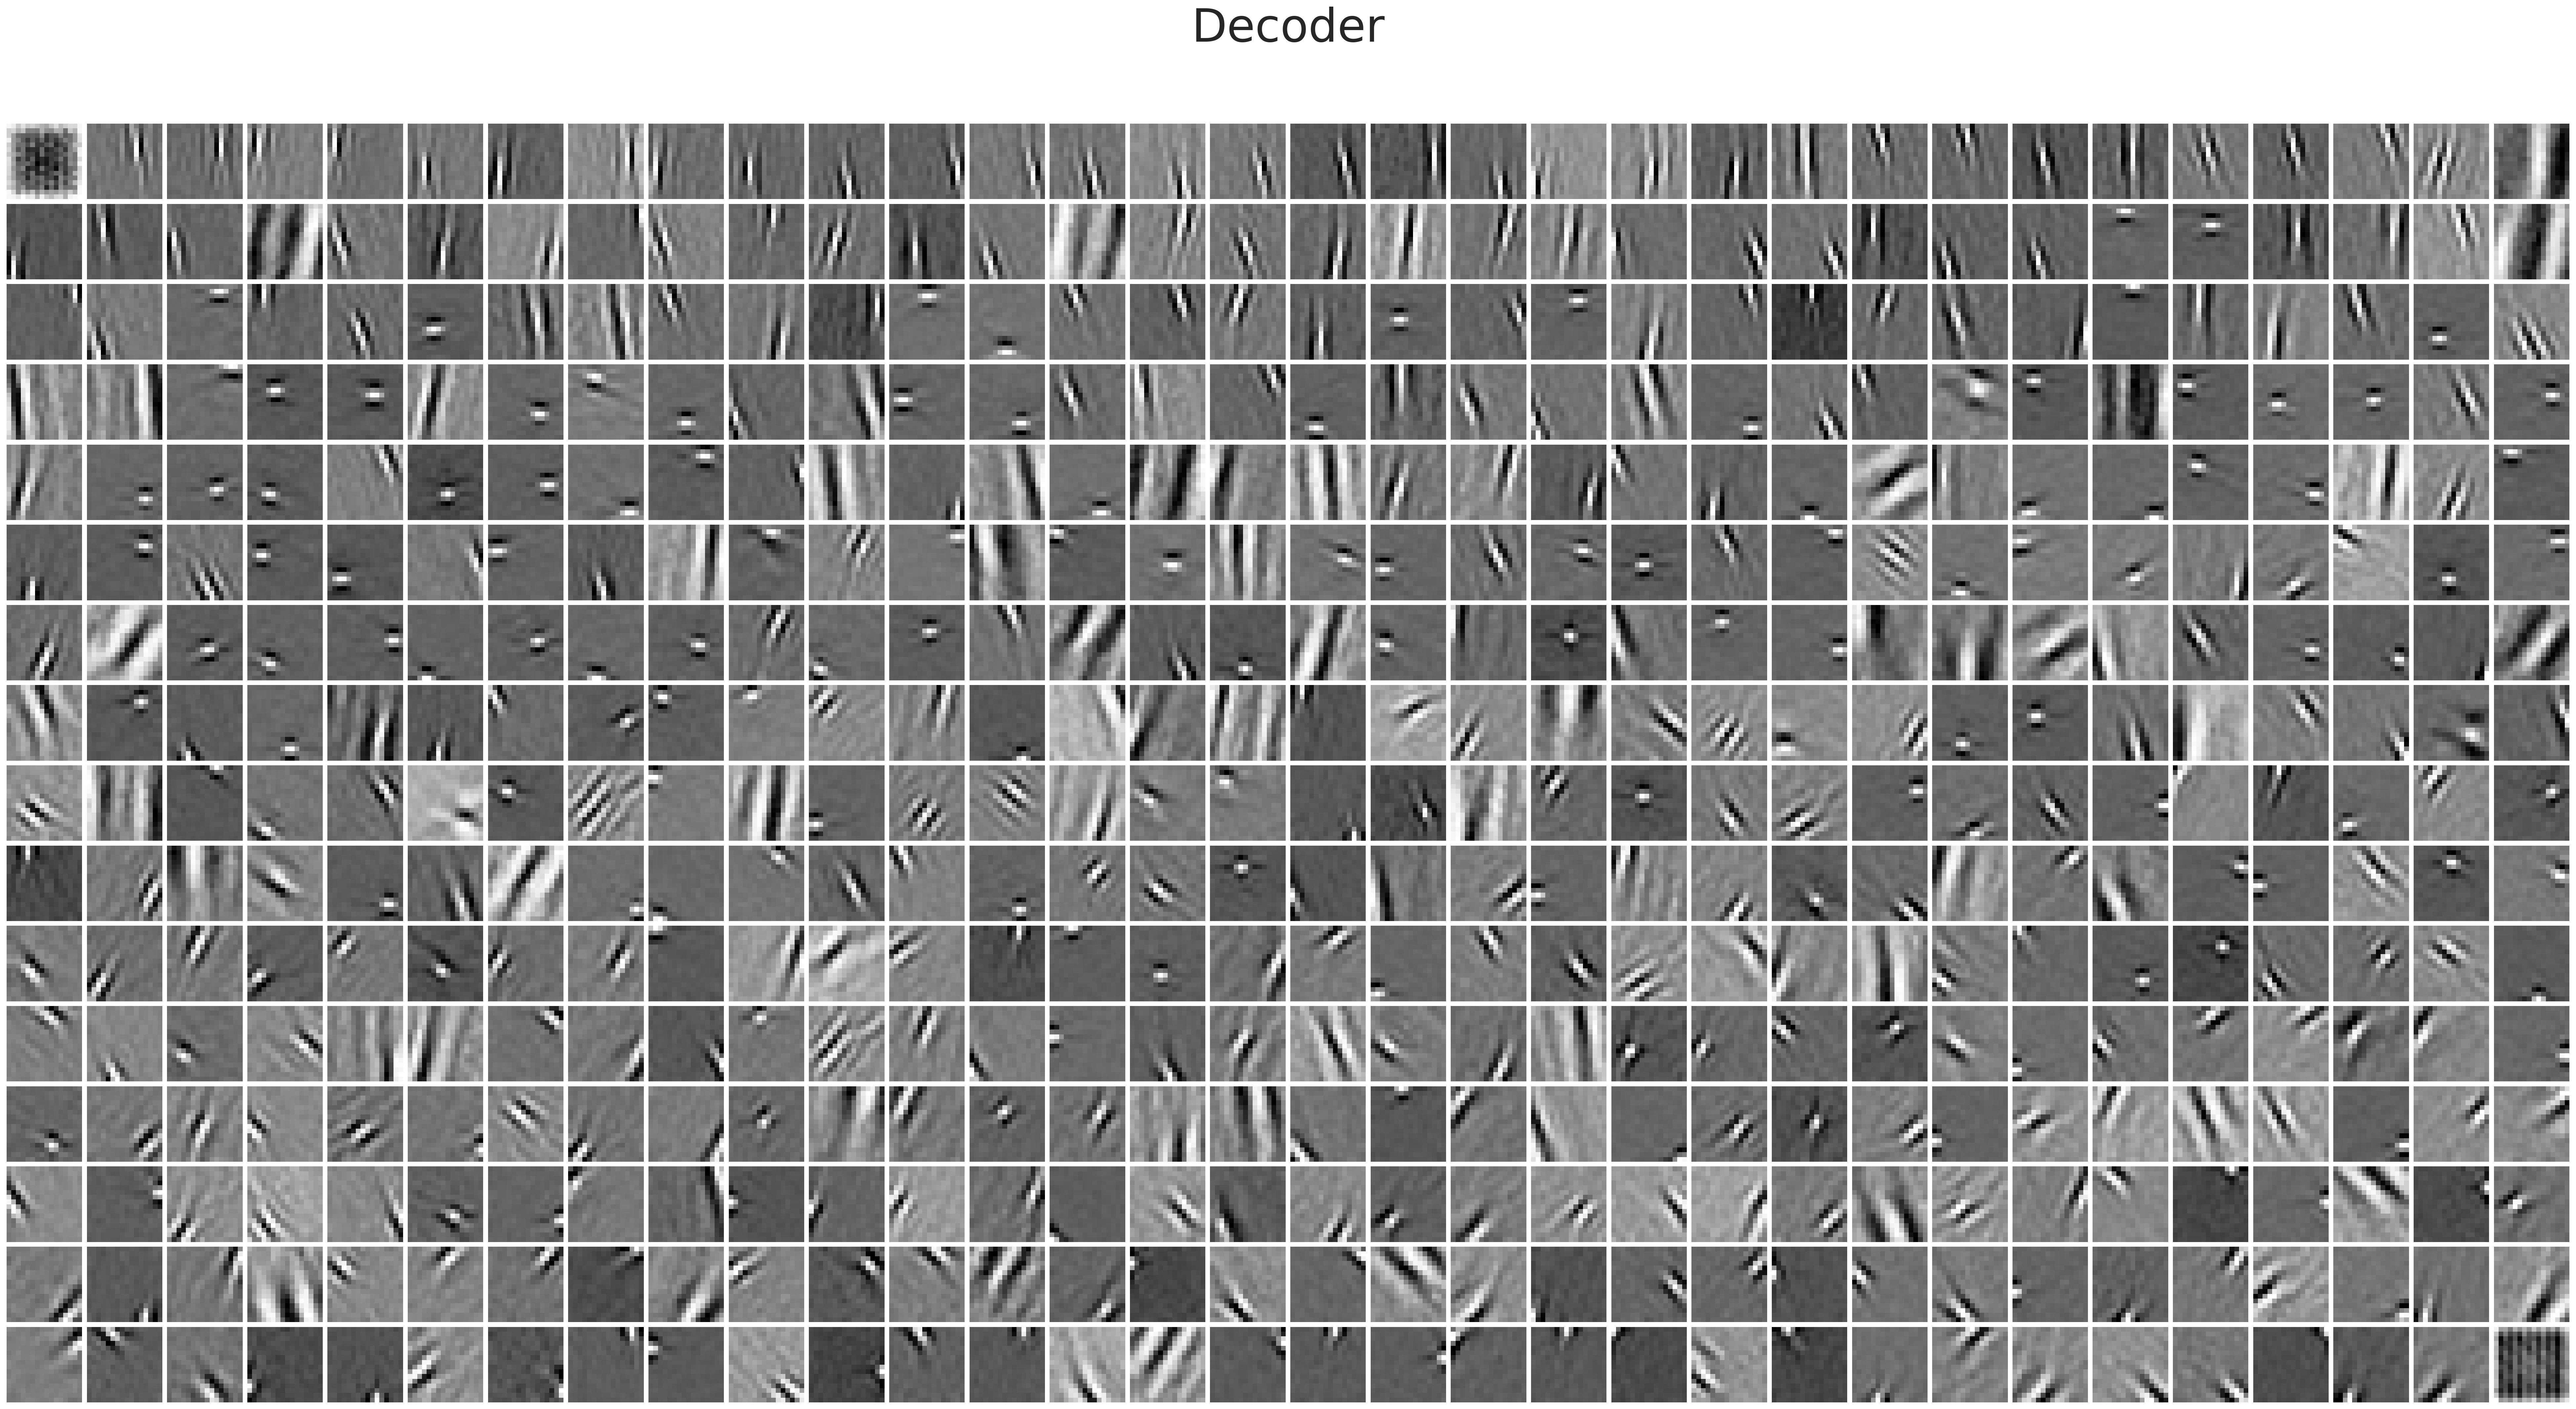

In [16]:
fig, ax = create_figure(1, 1, (50, 26), dpi=200)
ax.imshow(grid_dec, cmap='Greys_r')
ax.set_title('Decoder', fontsize=50, y=1.06)
remove_ticks(ax)
plt.show()

In [17]:
w_enc = tr.model.fc_enc.weight.reshape(tr.model.shape)
w_enc = to_np(w_enc[np.argsort(r8s)])
grid_enc = make_grid(w_enc, (16, 32))

w_enc.shape, grid_enc.shape

((512, 1, 16, 16), (271, 543))

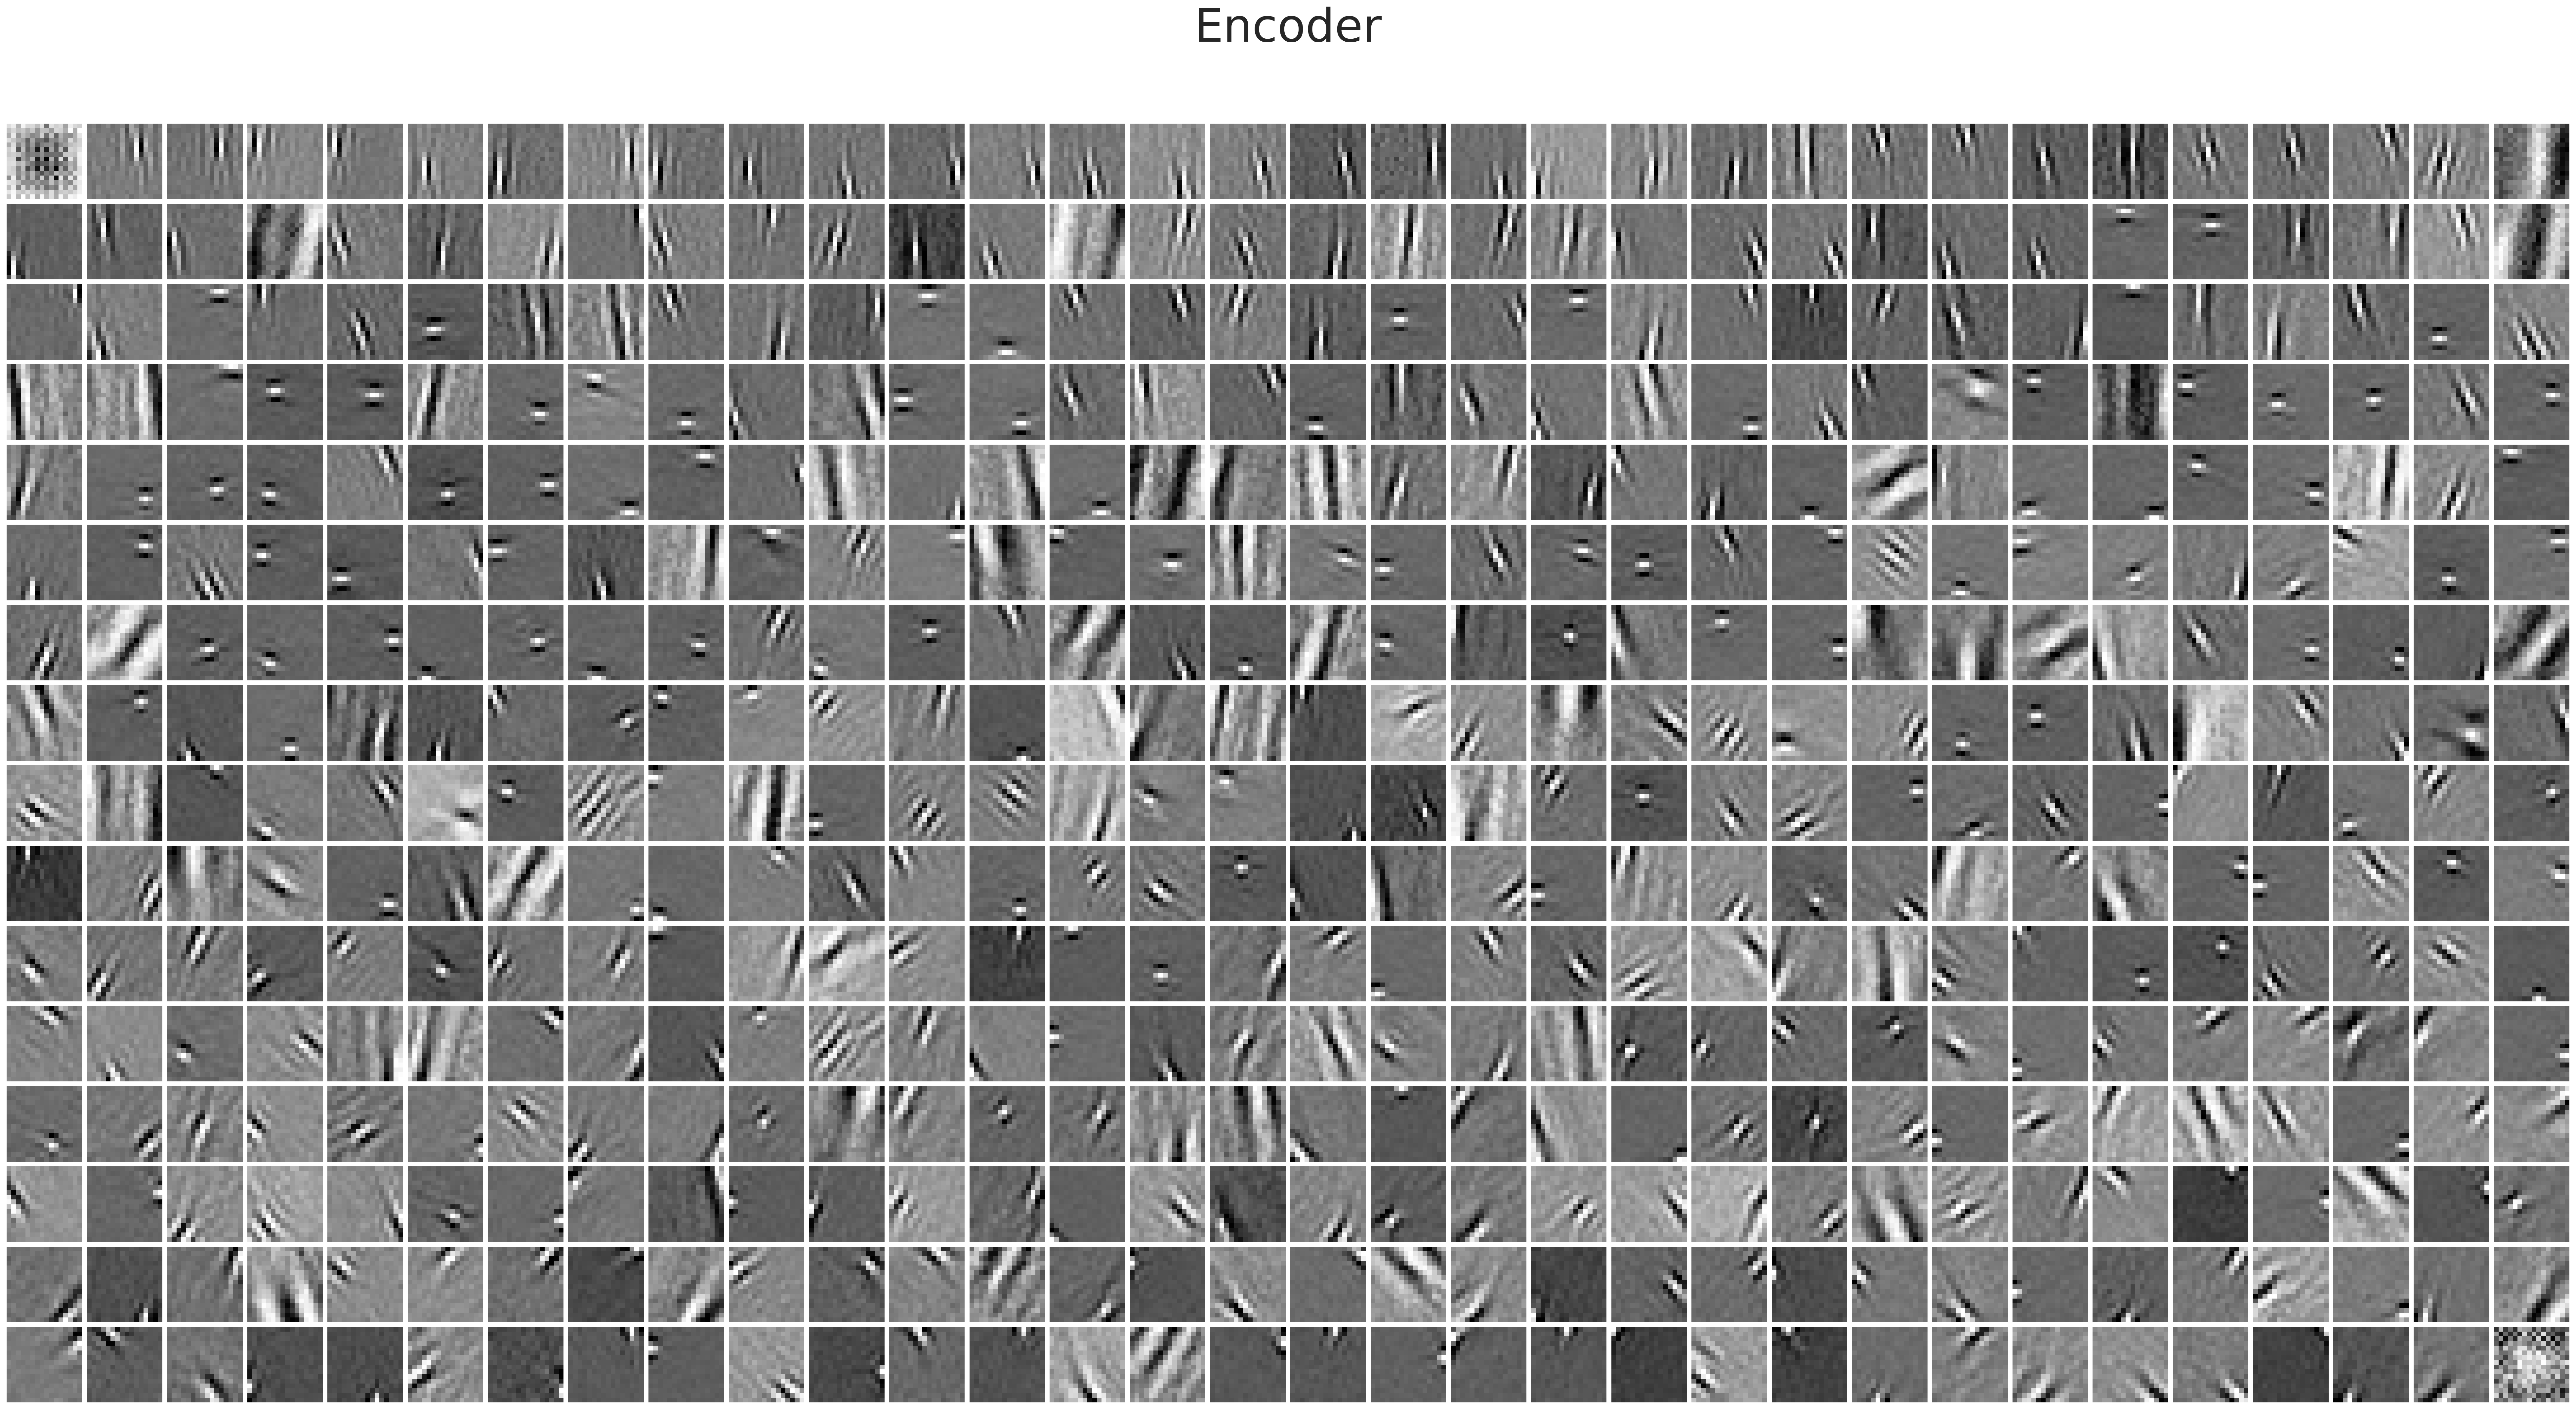

In [18]:
fig, ax = create_figure(1, 1, (50, 26), dpi=200)
ax.imshow(grid_enc, cmap='Greys_r')
ax.set_title('Encoder', fontsize=50, y=1.06)
remove_ticks(ax)
plt.show()

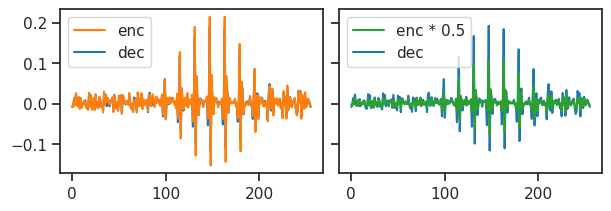

In [19]:
fig, axes = create_figure(1, 2, (6, 2), sharey='row', layout='constrained')

i = 5

axes[0].plot(w_enc[i].ravel(), label='enc', color='C1', zorder=1)
axes[1].plot(w_enc[i].ravel() * 0.5, label='enc * 0.5', color='C2', zorder=1)

for ax in axes.flat:
    ax.plot(w_dec[i].ravel(), label='dec', color='C0', zorder=0)
    ax.legend()

plt.show()

In [20]:
with torch.inference_mode():
    w_dec = tr.model.fc_dec.weight.detach().data
    w_enc = tr.model.fc_enc.weight.detach().data

    cos_sim = F.cosine_similarity(w_dec.T, w_enc)
    slope = torch.einsum('ic, ci -> c', w_dec, w_enc)
    slope /= torch.norm(w_enc, dim=1).pow(2)

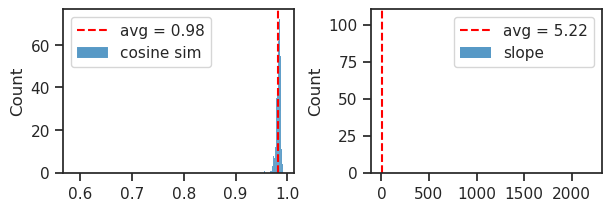

In [21]:
fig, axes = create_figure(1, 2, (6, 2), layout='constrained')

sns.histplot(to_np(cos_sim), label='cosine sim', ax=axes[0])
sns.histplot(to_np(slope), label='slope', ax=axes[1])

_avg = cos_sim.mean().item()
axes[0].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.2f}')
_avg = slope.mean().item()
axes[1].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.2f}')

for ax in axes.flat:
    ax.legend()
plt.show()

In [22]:
tot = np.prod(data['z'].shape)
portions = collections.Counter(data['z'].ravel().astype(int))
portions = {
    k: v / tot for k, v in
    portions.most_common()
}
portions = {
    k: np.round(v * 100, 1) for
    k, v in portions.items()
    if v > 0.001
}

In [23]:
portions

{0: 66.5, 1: 25.4, 2: 6.2, 3: 1.3, 4: 0.3, 9: 0.2}

{0: 70.8, 1: 22.7, 2: 5.0, 3: 1.0, 4: 0.2}

{0: 77.3, 1: 18.7, 2: 3.3, 3: 0.6, 4: 0.1}

In [27]:
sorted(r8s)

[0.003282039,
 0.15453428,
 0.16322255,
 0.19681042,
 0.19863841,
 0.20376612,
 0.20438114,
 0.21097071,
 0.21236841,
 0.21271653,
 0.21747683,
 0.21903588,
 0.22116661,
 0.22680958,
 0.23240195,
 0.2344353,
 0.23764187,
 0.2384357,
 0.24416648,
 0.24723573,
 0.2514792,
 0.25394058,
 0.25501376,
 0.2623543,
 0.2657037,
 0.26730478,
 0.2748054,
 0.27672464,
 0.2771406,
 0.28205797,
 0.2833833,
 0.286427,
 0.29158893,
 0.2918964,
 0.2928942,
 0.29512867,
 0.29549986,
 0.29725027,
 0.29854357,
 0.29879996,
 0.29994616,
 0.30242395,
 0.30306795,
 0.30611476,
 0.30749628,
 0.30777532,
 0.30815998,
 0.3083558,
 0.3091428,
 0.31343725,
 0.31411144,
 0.314664,
 0.31583098,
 0.31670263,
 0.3176045,
 0.31857628,
 0.32103348,
 0.3246184,
 0.32559603,
 0.3256601,
 0.3275228,
 0.3287695,
 0.32932973,
 0.32964236,
 0.33081168,
 0.3324067,
 0.33473578,
 0.33507422,
 0.33561096,
 0.33630008,
 0.33773196,
 0.33865413,
 0.34340417,
 0.34654275,
 0.3475542,
 0.3476075,
 0.3494828,
 0.35003808,
 0.3500971

In [36]:
loss['kl_diag'][np.argsort(r8s)] * 1000

array([ 2.6391373, 24.561205 , 22.785442 , 27.900738 , 26.666962 ,
       22.649233 , 23.687595 , 21.969023 , 22.576372 , 28.87226  ,
       27.812176 , 31.056705 , 26.624975 , 31.57518  , 28.423315 ,
       31.82637  , 36.09479  , 23.198471 , 33.57917  , 27.648605 ,
       23.908092 , 24.408772 , 27.465237 , 37.203793 , 33.437904 ,
       34.88865  , 25.832485 , 37.198    , 40.623535 , 35.073067 ,
       31.095062 , 27.86873  , 39.533497 , 37.7316   , 34.651688 ,
       27.334858 , 38.16381  , 26.665932 , 27.216797 , 37.26963  ,
       38.002663 , 31.655424 , 33.14877  , 32.54835  , 40.254433 ,
       28.441357 , 32.03993  , 43.828526 , 29.409693 , 25.537666 ,
       33.03289  , 24.957254 , 34.06206  , 49.05359  , 48.096344 ,
       32.205917 , 38.73702  , 45.29616  , 71.16861  , 63.793934 ,
       26.413334 , 27.763319 , 34.124577 , 31.444874 , 42.060295 ,
       37.651035 , 63.975773 , 39.129227 , 51.380756 , 70.19647  ,
       31.777002 , 27.683353 , 45.78679  , 31.387135 , 31.9143

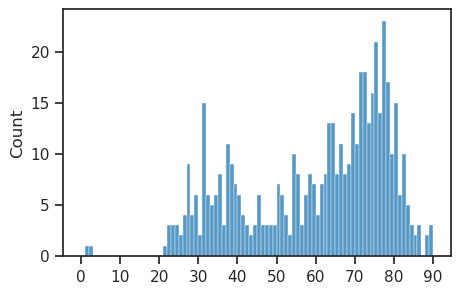

In [34]:
ax = sns.histplot(loss['kl_diag'] * 1000, bins=np.linspace(0, 90, 91))
ax.locator_params(axis='x', nbins=15)

In [35]:
20/1000

0.02

In [55]:
dead = loss['kl_diag'] < 0.02

r8s = rates['r*dr'].mean(0)
r8s = np.delete(r8s, dead)
len(r8s)

510

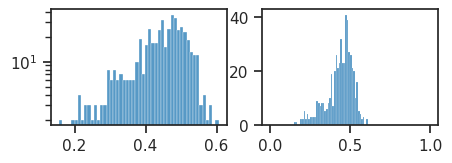

In [56]:
fig, axes = create_figure(1, 2, (5, 1.5))
sns.histplot(r8s, bins=50, ax=axes[0])
sns.histplot(r8s, bins=np.linspace(0, 1, 101), ax=axes[1])
for ax in axes.flat:
    ax.set_ylabel('')
axes[0].set_yscale('log')
plt.show()

In [63]:
w_dec = tr.model.fc_dec.weight.T.reshape(tr.model.shape)
w_dec = to_np(w_dec)
w_dec[dead] = np.nan

r8s = rates['r*dr'].mean(0)
w_dec = w_dec[np.argsort(r8s)]

grid_dec = make_grid(w_dec, (16, 32))

w_dec.shape, grid_dec.shape

((512, 1, 16, 16), (271, 543))

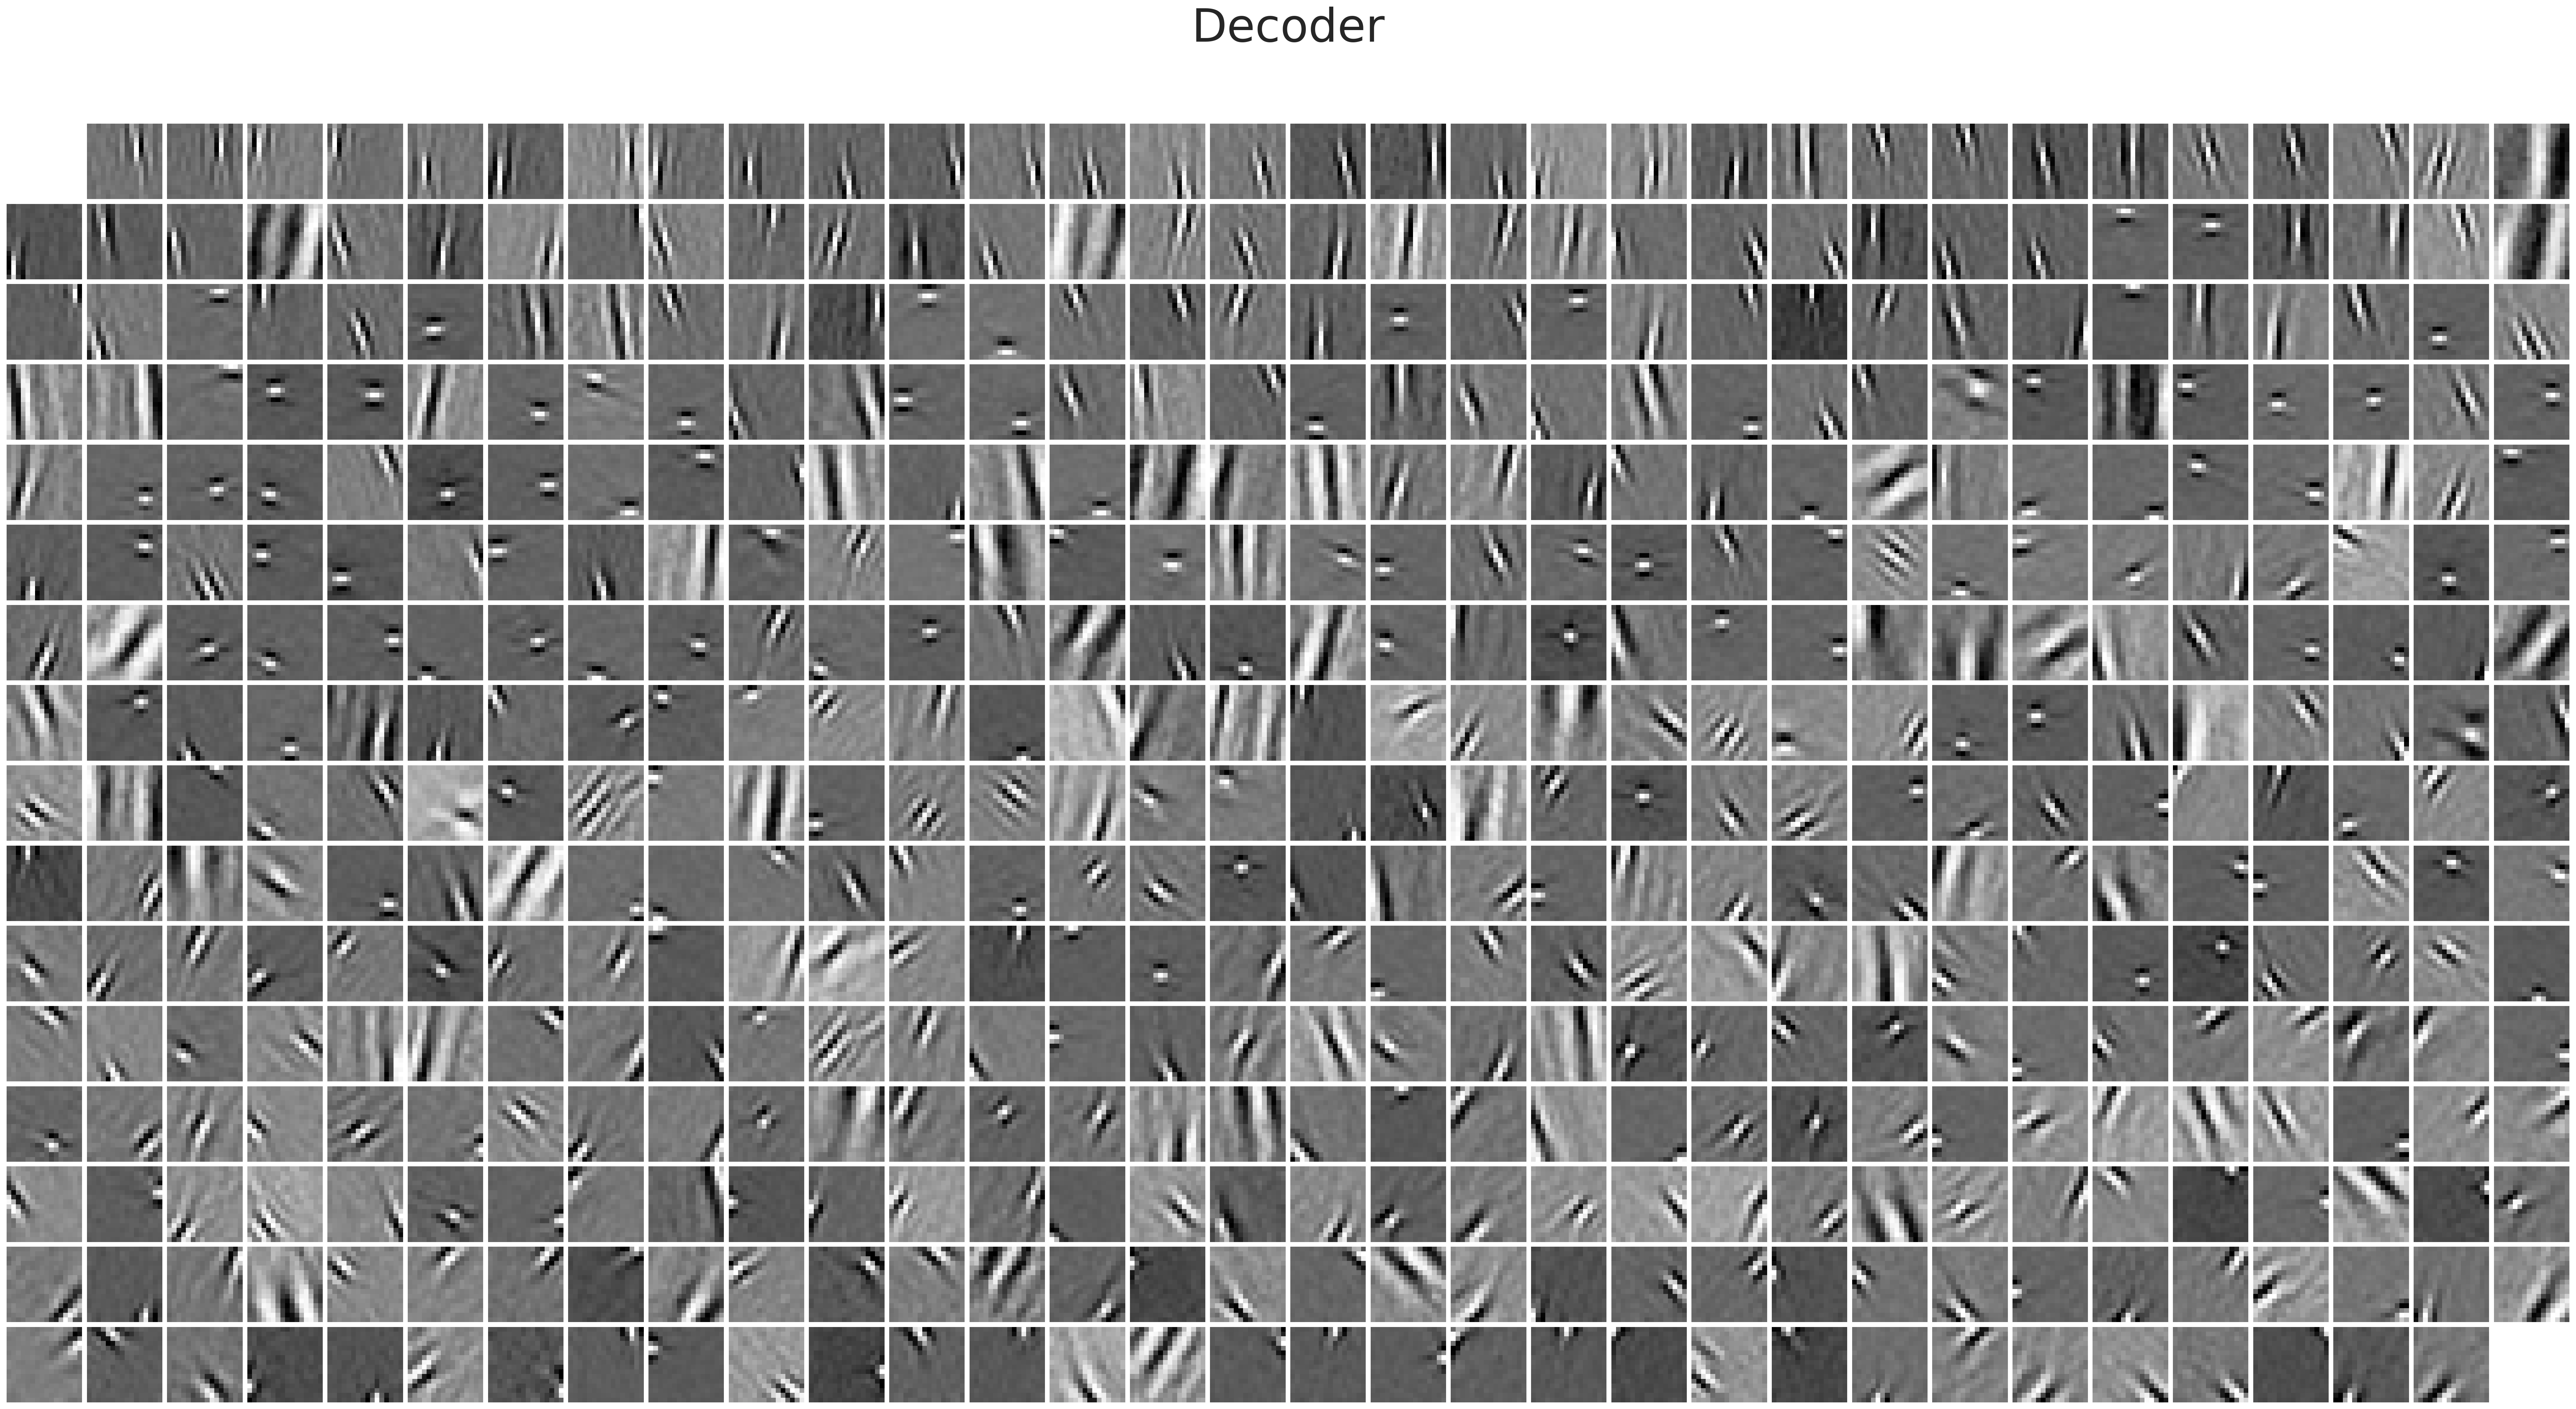

In [64]:
fig, ax = create_figure(1, 1, (50, 26), dpi=200)
ax.imshow(grid_dec, cmap='Greys_r')
ax.set_title('Decoder', fontsize=50, y=1.06)
remove_ticks(ax)
plt.show()

In [66]:
with torch.inference_mode():
    w_dec = tr.model.fc_dec.weight.detach().data
    w_enc = tr.model.fc_enc.weight.detach().data

    w_dec = w_dec[:, ~dead]
    w_enc = w_enc[~dead]

    cos_sim = F.cosine_similarity(w_dec.T, w_enc)
    slope = torch.einsum('ic, ci -> c', w_dec, w_enc)
    slope /= torch.norm(w_enc, dim=1).pow(2)

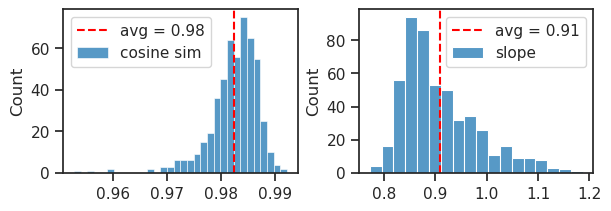

In [67]:
fig, axes = create_figure(1, 2, (6, 2), layout='constrained')

sns.histplot(to_np(cos_sim), label='cosine sim', ax=axes[0])
sns.histplot(to_np(slope), label='slope', ax=axes[1])

_avg = cos_sim.mean().item()
axes[0].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.2f}')
_avg = slope.mean().item()
axes[1].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.2f}')

for ax in axes.flat:
    ax.legend()
plt.show()

In [69]:
tot = np.prod(data['z'].shape)
portions = data['z'][:, ~dead].ravel().astype(int)
portions = collections.Counter(portions)
portions = {
    k: v / tot for k, v in
    portions.most_common()
}
portions = {
    k: np.round(v * 100, 1) for
    k, v in portions.items()
    if v > 0.001
}

In [70]:
portions

{0: 66.3, 1: 25.4, 2: 6.2, 3: 1.3, 4: 0.3}

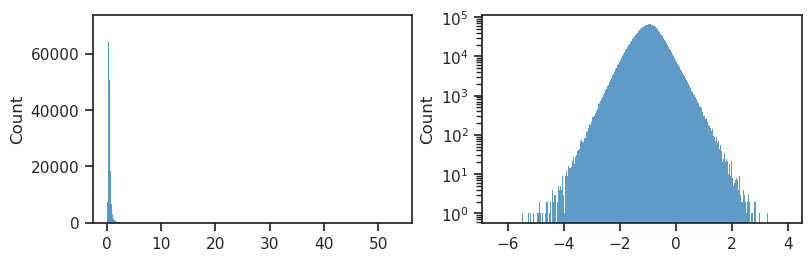

In [76]:
x2p = rates['r*dr'][:, ~dead].ravel()

fig, axes = create_figure(1, 2, (8, 2.5), layout='constrained')
sns.histplot(x2p, ax=axes[0])
sns.histplot(np.log(x2p), ax=axes[1])
axes[1].set_yscale('log')